## Imports packages

In [3]:
import os
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from torchvision import transforms

## Load Dataset

In [2]:
from utils.Dataloader import DataLoader

path = './data'
dataset = DataLoader(path)

## Exploratory Data Analysis (EDA)

In [3]:
print("Number of monet paintings: {}".format(len(dataset.monet_indices)))
print("Number of photos: {}".format(len(dataset.photo_indices)))

Number of monet paintings: 300
Number of photos: 7038


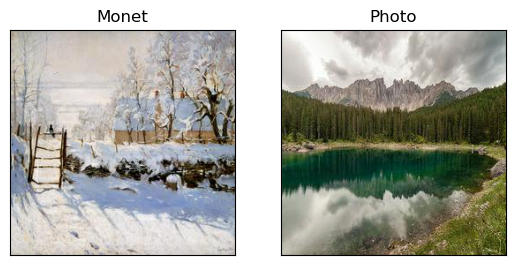

In [4]:
path_monet = os.path.join(path, "monet_jpg")
path_photo = os.path.join(path, "photo_jpg")

random_index = int(np.random.uniform(0, len(dataset.monet_indices)))
example_monet = dataset.monet_indices[random_index]
example_photo = dataset.photo_indices[random_index]

plt.subplot(121)
plt.title('Monet')
plt.imshow(Image.open(os.path.join(path_monet, example_monet)))
plt.xticks([])
plt.yticks([])

plt.subplot(122)
plt.title('Photo')
plt.imshow(Image.open(os.path.join(path_photo, example_photo)))
plt.xticks([])
plt.yticks([])
plt.show()

Monet:


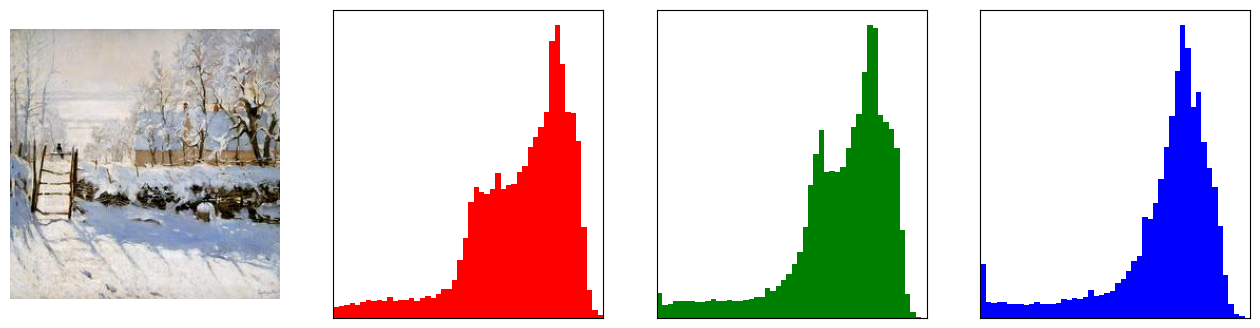

Photo:


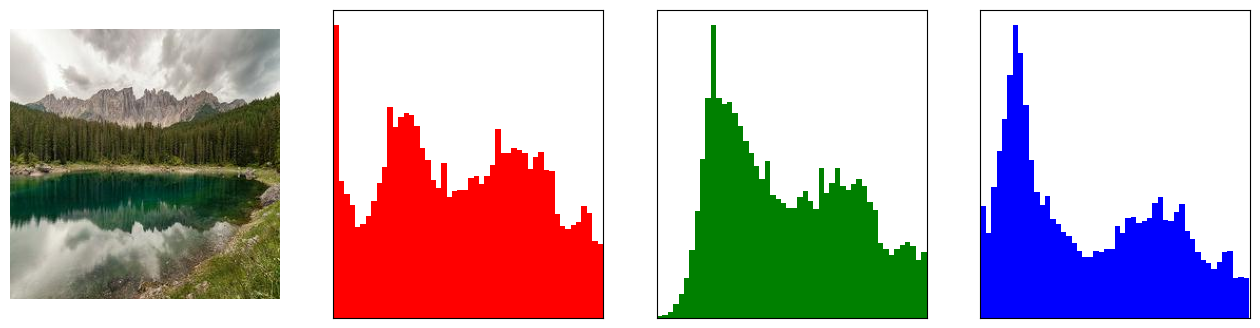

In [5]:
# function to display the present color channels in an image alongside the image itself
def display_color_channels(path):
    plt.figure(figsize=(16, 4))
    
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    plt.subplot(1, 4, 1)
    plt.imshow(img)
    plt.axis("off")
    
    colors = ["red", "green", "blue"]
    for i in range(len(colors)):
        plt.subplot(1, 4, i + 2)
        plt.hist(
            img[:, :, i].reshape(-1),
            bins=50,
            color=colors[i],
            density=True
        )
        plt.xlim(0, 255)
        plt.xticks([])
        plt.yticks([])
     
    plt.show()

# show monet example color channels
print("Monet:")
display_color_channels(os.path.join(path_monet, example_monet))
print("Photo:")
display_color_channels(os.path.join(path_photo, example_photo))

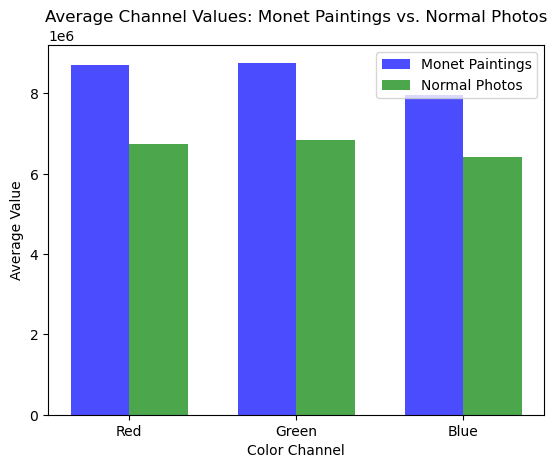

In [6]:
# function to calculate the average channel values (Red, Green, Blue)
def calculate_average_channel_values(image_dir):
    
    # init each channel (R, G, B)
    channel_sum = np.zeros(3) 
    total_images = 0

    for image_filename in os.listdir(image_dir):
        img = Image.open(os.path.join(image_dir, image_filename))
        img_array = np.array(img)
        
        # make sure it is a color image
        if img_array.shape == (256, 256, 3):
            channel_sum += np.sum(img_array, axis=(0, 1))
            total_images += 1

    average_channel_values = channel_sum / total_images
    return average_channel_values

# calculate average channel values
average_monet_values = calculate_average_channel_values(path_monet)
average_photos_values = calculate_average_channel_values(path_photo)

# ceate bar charts to compare average channel values
channels = ['Red', 'Green', 'Blue']
x = np.arange(len(channels))
width = 0.35

plt.bar(x - width/2, average_monet_values, width, label='Monet Paintings', color='b', alpha=0.7)
plt.bar(x + width/2, average_photos_values, width, label='Normal Photos', color='g', alpha=0.7)

plt.xlabel('Color Channel')
plt.ylabel('Average Value')
plt.title('Average Channel Values: Monet Paintings vs. Normal Photos')
plt.xticks(x, channels)
plt.legend()
plt.show()

## Model Training

In [1]:
import torch
from torch import nn
from itertools import chain
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler
from utils.Architecture import Generator, Discriminator

class Model(torch.nn.Module):
    def __init__(self, epochs, device, cycle_lambda = 10, Learning_rate=2e-4):
        super(Model,self).__init__()
        self.device = device
        
        self.gen_monet2photo = Generator(input_channel=3).to(self.device)
        self.gen_photo2monet = Generator(input_channel=3).to(self.device)
        self.disc_monet = Discriminator(input_channel=3).to(self.device)
        self.disc_photo = Discriminator(input_channel=3).to(self.device)

        # Optimizer for the generator and discriminators
        self.opt_gen = torch.optim.Adam(chain(self.gen_monet2photo.parameters(), self.gen_photo2monet.parameters()),
                                         lr = Learning_rate,
                                         betas= (0.5, 0.999))
        self.opt_disc = torch.optim.Adam(chain(self.disc_monet.parameters(), self.disc_photo.parameters()),
                                         lr = Learning_rate,
                                         betas= (0.5, 0.999))
        
        self.L1 = nn.L1Loss().to(self.device)
        self.mse = nn.MSELoss().to(self.device) 
        self.cycle_lambda = cycle_lambda
        self.epochs = epochs

        self.D_scaler = GradScaler()
        self.G_scaler = GradScaler()
        
        self.zero_tensor = None
        self.Tensor = torch.FloatTensor
    def init_weights(self):
        pass

    # Generate and add noise to the inputs of the discriminator
    def add_noise(self, tensor, noise_level=0.05):
        """
        Adds Gaussian noise to the input tensor.
        Args:
            tensor (torch.Tensor): Input tensor to which noise will be added.
            noise_level (float): Standard deviation of the Gaussian noise.
        Returns:
            torch.Tensor: Tensor with added noise.
        """
        if noise_level > 0:
            noise = torch.randn_like(tensor) * noise_level
            return tensor + noise
        return tensor
    
    """ From https://github.com/NVlabs/SPADE/blob/master/models/networks/loss.py """
    def get_zero_tensor(self, input):
        if self.zero_tensor is None:
            self.zero_tensor = self.Tensor(1).fill_(0)
            self.zero_tensor.requires_grad_(False)
        return self.zero_tensor.expand_as(input)
    def hinge_loss(self, input, target_is_real, for_discriminator = False):
        if for_discriminator:
            if target_is_real:
                minval = torch.min(input - 1, self.get_zero_tensor(input))
                loss = -torch.mean(minval)
            else:
                minval = torch.min(-input - 1, self.get_zero_tensor(input))
                loss = -torch.mean(minval)
        else:
            assert target_is_real, "The generator's hinge loss must be aiming for real"
            loss = -torch.mean(input)
        return loss
    
    def train(self, dataloader):
        for epoch in range(self.epochs):
            avg_G_loss = 0.0
            avg_D_loss = 0.0

            reals = 0
            fakes = 0
            print("\nEpoch {}/{}".format(epoch+1, self.epochs))
            loop = tqdm(dataloader, leave=True, total=len(dataloader))
            noise_level = max(0.05, 0.05 * (1 - epoch / self.epochs))
            for i, (photo, monet) in enumerate(loop):
                photo, monet = photo.to(self.device), monet.to(self.device)
                
                if i >= len(dataloader) - 1:  # Ensure no more than the intended batches
                    break

                # Train discriminators Between photo and monet
                with autocast():
                    # Generate fake photo to train photos discriminator 
                    fake_photo = self.gen_monet2photo(monet)
                    D_photo = self.disc_photo(self.add_noise(photo, noise_level))
                    D_fake_photo = self.disc_photo(self.add_noise(fake_photo.detach(), noise_level))
                    reals += D_photo.mean().item()
                    fakes += D_fake_photo.mean().item()
                    # Use the hinge loss between the discriminator output
                    # and the label (Real photo is 1 and the generated one is 0)
                    D_real_photo_loss = self.mse(D_photo, torch.ones_like(D_photo))
                    D_fake_photo_loss = self.mse(D_fake_photo, torch.zeros_like(D_fake_photo))

                    D_photo_loss = (D_real_photo_loss + D_fake_photo_loss) / 2

                    # Generate fake monet pictures to train monets discriminator
                    fake_monet = self.gen_photo2monet(photo)
                    D_monet = self.disc_monet(self.add_noise(monet, noise_level))
                    D_fake_monet = self.disc_monet(self.add_noise(fake_monet.detach(), noise_level))
                    # Use the mean squared error between the discriminator output
                    # and the label (Real monet is 1 and the generated monet is 0)
                    D_real_monet_loss = self.mse(D_monet, torch.ones_like(D_monet))
                    D_fake_monet_loss = self.mse(D_fake_monet, torch.zeros_like(D_fake_monet))
                    D_monet_loss = (D_real_monet_loss + D_fake_monet_loss) / 2
                    total_D_loss = D_monet_loss + D_photo_loss
                    avg_D_loss += total_D_loss.item()
                self.opt_disc.zero_grad()
                self.D_scaler.scale(total_D_loss).backward()  
                self.D_scaler.step(self.opt_disc)  
                self.D_scaler.update() 
                

                # Train generators for photo and monet images
                with autocast():

                    # adversarial losses
                    D_fake_photo = self.disc_photo(self.add_noise(fake_photo.detach(), noise_level))
                    D_fake_monet = self.disc_monet(self.add_noise(fake_monet.detach(), noise_level))
                    G_fake_photo_loss = self.hinge_loss(D_fake_photo, True, False)
                    G_fake_monet_loss = self.hinge_loss(D_fake_monet, True, False)
                    # cycle losses
                    cycle_monet = self.gen_photo2monet(fake_photo)
                    cycle_photo = self.gen_monet2photo(fake_monet)
                   
                    cycle_monet_loss = self.L1(monet, cycle_monet)
                    cycle_photo_loss = self.L1(photo, cycle_photo)
    
                    # total loss
                    total_G_loss = (
                        G_fake_photo_loss
                        + G_fake_monet_loss
                        + cycle_monet_loss * self.cycle_lambda
                        + cycle_photo_loss * self.cycle_lambda
                    )
                    avg_G_loss += total_G_loss.item()
                self.opt_gen.zero_grad()
                self.G_scaler.scale(total_G_loss).backward()  
                self.G_scaler.step(self.opt_gen)  
                self.G_scaler.update()
                loop.set_postfix(Monet_Real=reals / (i + 1), Monet_fake=fakes / (i + 1))
            print("Generator Loss:%f  -  Discriminator Loss:%f" % (avg_G_loss, avg_D_loss))
            
    def test(self, photo, monet):
        results = []
        
        photo, monet = photo.to(self.device), monet.to(self.device)

        generated_monet = self.gen_photo2monet(photo)

        # Pass the monet and generated images through the discriminator
        generated_score = self.disc_monet(generated_monet.detach())
        real_score = self.disc_monet(monet)
        generated_score = generated_score.mean().item()
        real_score = real_score.mean().item()
        
        results.append({
            "generated_score": generated_score,
            "real_score": real_score,
            "generated_image": generated_monet.detach().cpu()  # Detach and move to CPU
        })
        return results
        

In [4]:
gan = Model(1, 'cpu')
gan.train(dataset)

/var/folders/z2/m5_kp65x4ydbtt3mq8bcpw_r0000gn/T/ipykernel_71590/2875939794.py:31: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.D_scaler = GradScaler()
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/var/folders/z2/m5_kp65x4ydbtt3mq8bcpw_r0000gn/T/ipykernel_71590/2875939794.py:32: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.G_scaler = GradScaler()



Epoch 1/1


  0%|          | 0/300 [00:00<?, ?it/s]/var/folders/z2/m5_kp65x4ydbtt3mq8bcpw_r0000gn/T/ipykernel_71590/2875939794.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:265: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/z2/m5_kp65x4ydbtt3mq8bcpw_r0000gn/T/ipykernel_71590/2875939794.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|█████████▉| 299/300 [52:40<00:10, 10.57s/it, Monet_Real=0.765, Monet_fake=0.355] 

Generator Loss:860.897031  -  Discriminator Loss:85.797814


## Compare results before and after training

### Before Training

In [9]:
data_iter = iter(dataset)
images, monet = next(data_iter)

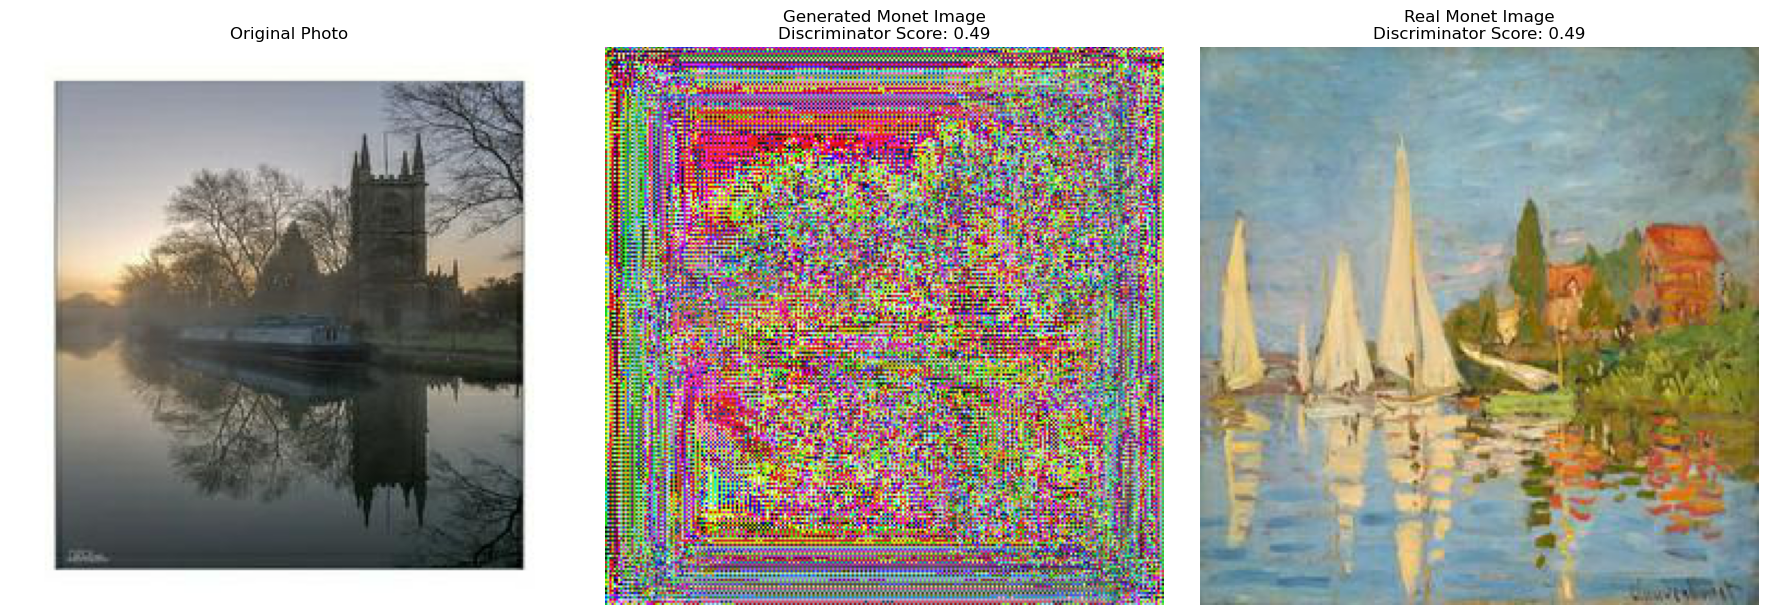

In [10]:
generator = Generator(input_channel=3)
generated_monet = generator(images)

discriminator = Discriminator(input_channel=3)
# Pass the monet and generated images through the discriminator
generated_score = discriminator(generated_monet)
real_score = discriminator(monet)
generated_score = generated_score.mean().item()
real_score = real_score.mean().item()

# Plotting the real photo, generated Monet-like image, and discriminator scores
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Original photo
axes[0].imshow(transforms.ToPILImage()(images.cpu().squeeze()))
axes[0].set_title("Original Photo")
axes[0].axis('off')

# Generated Monet-like image
axes[1].imshow(transforms.ToPILImage()(generated_monet))
axes[1].set_title(f"Generated Monet Image\nDiscriminator Score: {generated_score:.2f}")
axes[1].axis('off')

# Real Monet painting with discriminator score
axes[2].imshow(transforms.ToPILImage()(monet.cpu().squeeze()))
axes[2].set_title(f"Real Monet Image\nDiscriminator Score: {real_score:.2f}")
axes[2].axis('off')

plt.tight_layout()
plt.show()

### After training

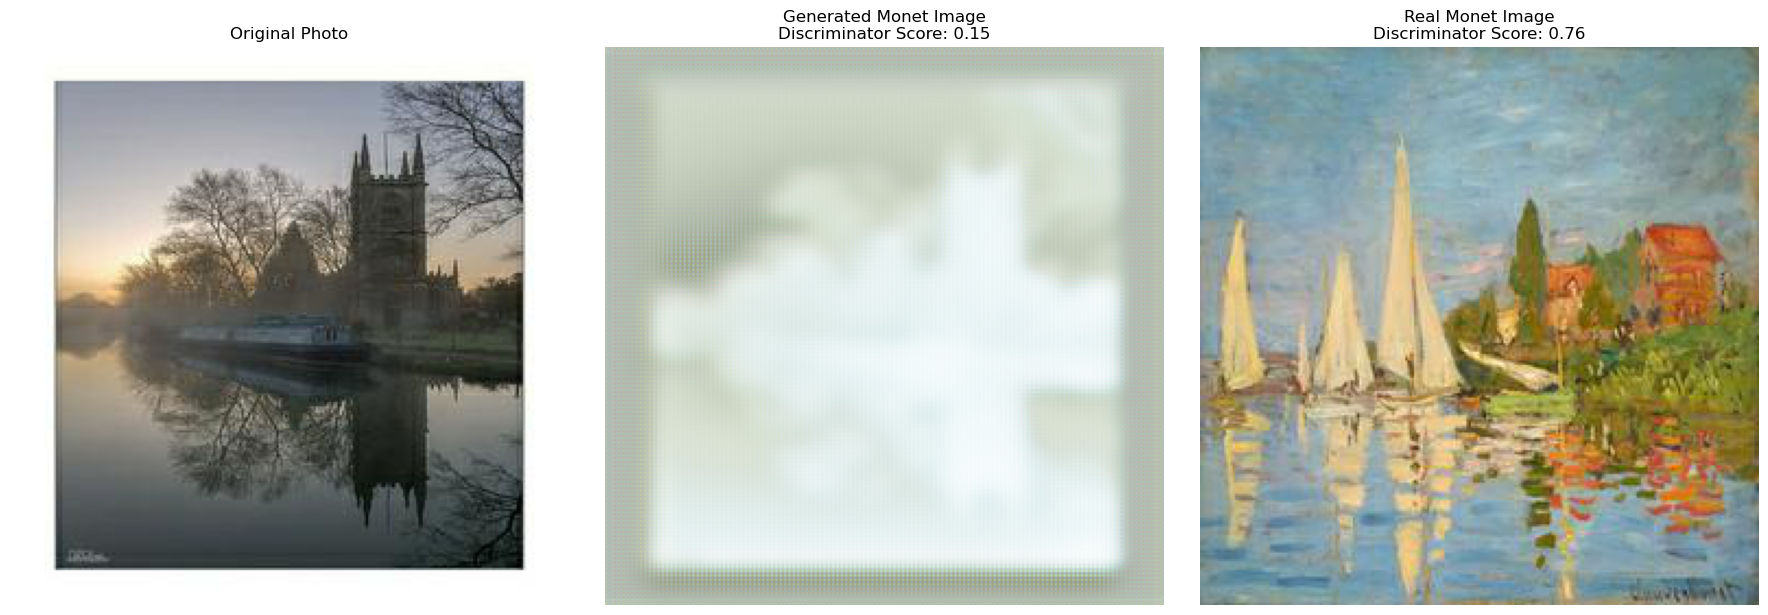

In [11]:
result = gan.test(images, monet)

# Pass the monet and generated images through the discriminator
generated_monet = result[0]["generated_image"]
generated_score = result[0]["generated_score"]
real_score =result[0]["real_score"]
generated_monet =generated_monet .permute(1, 2, 0).numpy() * 0.5 + 0.5 
# img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)


# Plotting the real photo, generated Monet-like image, and discriminator scores
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Original photo
axes[0].imshow(transforms.ToPILImage()(images.cpu().squeeze()))
axes[0].set_title("Original Photo")
axes[0].axis('off')

# Generated Monet-like image
axes[1].imshow(transforms.ToPILImage()(generated_monet))
axes[1].set_title(f"Generated Monet Image\nDiscriminator Score: {generated_score:.2f}")
axes[1].axis('off')

# Real Monet painting with discriminator score
axes[2].imshow(transforms.ToPILImage()(monet.cpu().squeeze()))
axes[2].set_title(f"Real Monet Image\nDiscriminator Score: {real_score:.2f}")
axes[2].axis('off')

plt.tight_layout()
plt.show()